In this notebook we analyze the movement of the head while walking and running.
This is done to figure out the design of the induction generator. 

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Index(['Time (s)', 'Linear Acceleration x (m/s^2)',
       'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)',
       'Absolute acceleration (m/s^2)'],
      dtype='object')


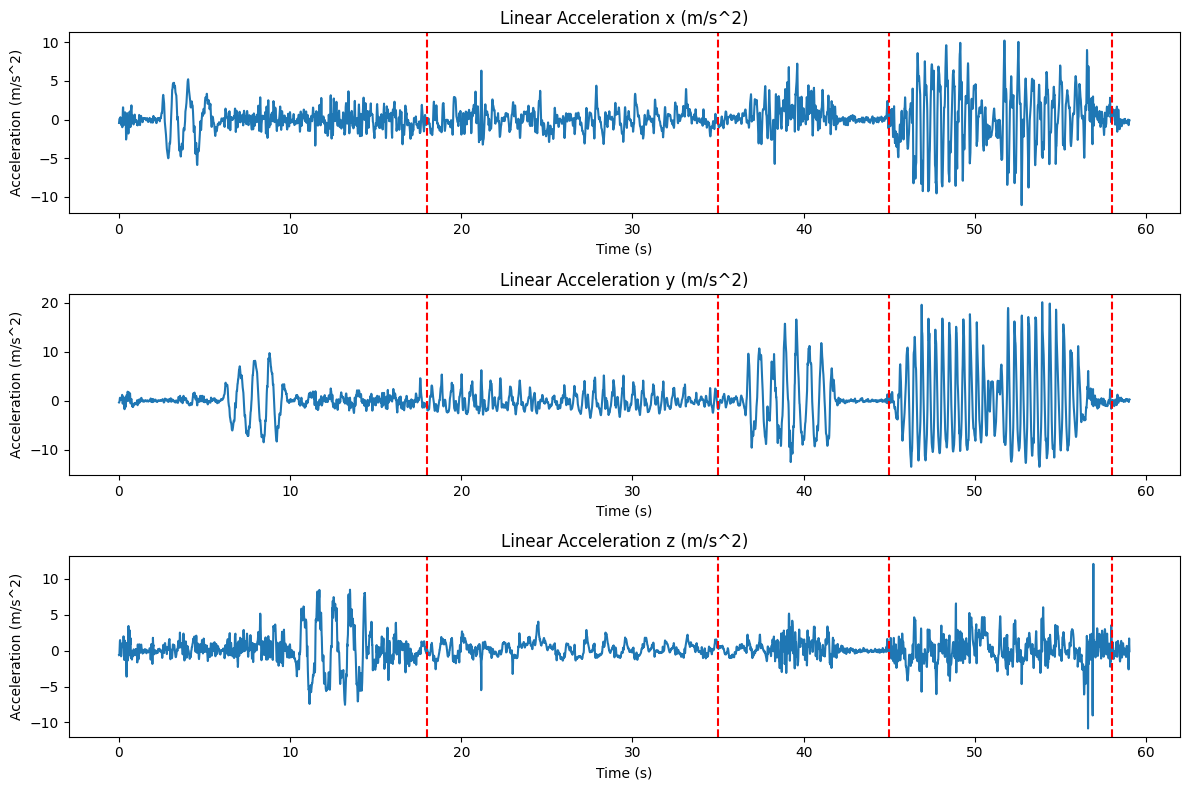

In [18]:
# This data is from the phone accelerometer.
# It was recorded with the phyphox app.
# The phone was held in the right hand at the right ear so that the top of the phone was pointing upwards.
# From a person looking perspective looking forward the x, y, and z axes correspond to front, up, and right respectively.
# To indicate the start of the experiment the dataset starts with periodic movement first into the x direction, then into the y direction, and finally into the z direction.
# The first part of the dataset is walking and the second part is running. Walking and running are separated by a strong periodic movement into the y direction and a short pause.
df = pd.read_csv('../data/recorded/phone-walking-and-running/Acceleration without g 2024-06-27 11-58-04/Raw Data.csv')

print(df.columns)

def create_accelerations_figure(df):
    # Plot the data
    fig = plt.figure(figsize=(12, 8))
    x_plot = fig.add_subplot(3, 1, 1)
    y_plot = fig.add_subplot(3, 1, 2)
    z_plot = fig.add_subplot(3, 1, 3)

    x_plot.plot(df['Time (s)'], df['Linear Acceleration x (m/s^2)'])
    x_plot.set_title('Linear Acceleration x (m/s^2)')
    x_plot.set_xlabel('Time (s)')
    x_plot.set_ylabel('Acceleration (m/s^2)')


    y_plot.plot(df['Time (s)'], df['Linear Acceleration y (m/s^2)'])
    y_plot.set_title('Linear Acceleration y (m/s^2)')
    y_plot.set_xlabel('Time (s)')
    y_plot.set_ylabel('Acceleration (m/s^2)')

    z_plot.plot(df['Time (s)'], df['Linear Acceleration z (m/s^2)'])
    z_plot.set_title('Linear Acceleration z (m/s^2)')
    z_plot.set_xlabel('Time (s)')
    z_plot.set_ylabel('Acceleration (m/s^2)')

    return fig

fig = create_accelerations_figure(df)

walking_start = 18
walking_end = 35
running_start = 45
running_end = 58


# Apply lines to each plot for each event.
for ax in fig.get_axes():
    ax.axvline(x=walking_start, color='r', linestyle='--', label='Event Marker')
    ax.axvline(x=walking_end, color='r', linestyle='--', label='Event Marker')
    ax.axvline(x=running_start, color='r', linestyle='--', label='Event Marker')
    ax.axvline(x=running_end, color='r', linestyle='--', label='Event Marker')

plt.tight_layout()
plt.show()

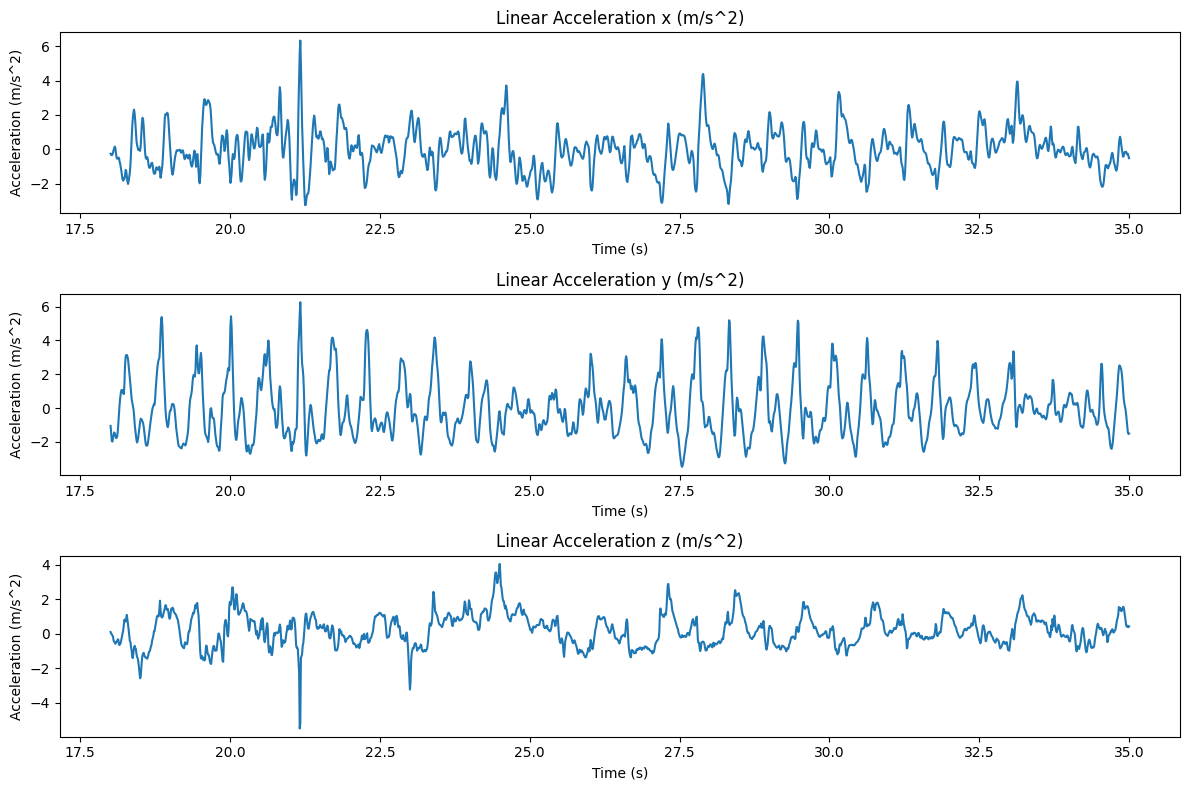

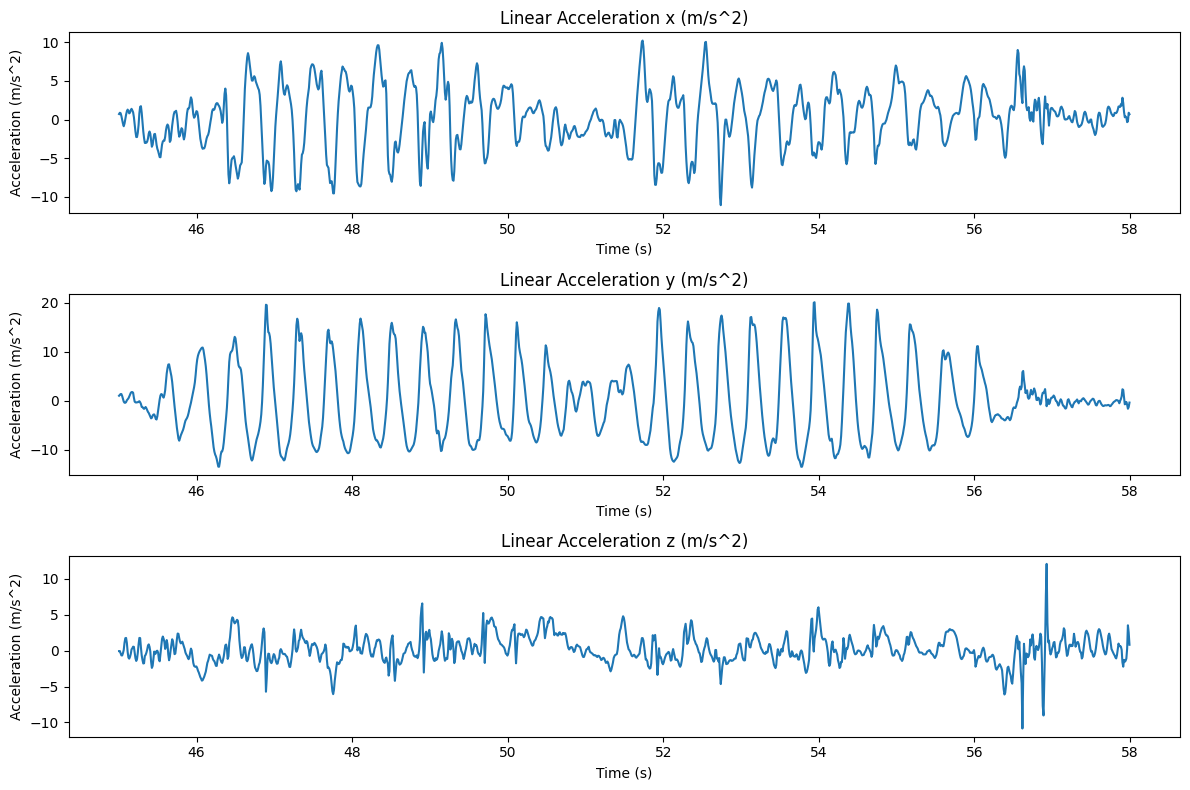

In [22]:
walking_df = df[(df['Time (s)'] >= walking_start) & (df['Time (s)'] <= walking_end)]
running_df = df[(df['Time (s)'] >= running_start) & (df['Time (s)'] <= running_end)]

create_accelerations_figure(walking_df)

plt.tight_layout()
plt.show()

create_accelerations_figure(running_df)
plt.tight_layout()
plt.show()




In [89]:
from scipy.signal import butter, filtfilt
# Do some high level analysis of the data. From looking at the figures we see that running and walking are qualitatively very similar.
# Only the amplitude of the accelerations is different.
# Here we define a function that extracts key charachteristics of the movement.
# We will find the frequence of the movement and the amplitude of the movement.

def analyze_movement_characteristics(df):
    # Use fast fourier transform to find the frequencies of the movement.

    def determine_frequency(time_series, cutoff_frequency=10, filter_order=3, show_plots=True):
        """
        Takes in a time series of accelerations along one axis, applies a low-pass filter,
        computes the FFT and plots the time series and power spectrum.

        Parameters:
        - time_series (pd.Series): Time series data with a numerical index in seconds.
        - cutoff_frequency (float): Cutoff frequency for the low-pass filter in Hz.
        - filter_order (int): Order of the low-pass filter.
        - show_plots (bool): Whether to display the plots or not.

        Returns:
        - dominant_frequency (float): The dominant frequency in the filtered time series data.
        """

        # Compute the sampling rate
        sampling_rate = len(time_series) / (time_series.index[-1] - time_series.index[0])

        def lowpass_filter(data, cutoff_freq, sampling_rate, order=3):
            """
            Applies a low-pass Butterworth filter to the data.
            """
            nyquist = 0.5 * sampling_rate
            normal_cutoff = cutoff_freq / nyquist
            b, a = butter(order, normal_cutoff, btype='low', analog=False)
            filtered_data = filtfilt(b, a, data, method="pad")
            return filtered_data

        # Apply the low-pass filter to the time series data
        smoothed_time_series = lowpass_filter(time_series.values.flatten(), cutoff_frequency, sampling_rate, filter_order)

        # Apply FFT to the filtered data
        n = len(smoothed_time_series)
        time_series_fft = np.fft.fft(smoothed_time_series)
        frequencies = np.fft.fftfreq(n, d=1/sampling_rate)

        # Compute the power spectrum
        power_spectrum = np.abs(time_series_fft)**2

        # Identify the dominant frequency
        dominant_frequency_index = np.argmax(power_spectrum[:n//2])
        dominant_frequency = frequencies[dominant_frequency_index]

        if show_plots:
            # Create plots for both the time series and the power spectrum
            plt.figure(figsize=(14, 8))

            # Plot the original and filtered time series data
            plt.subplot(2, 1, 1)
            plt.plot(time_series.index, time_series.values, label='Original')
            plt.plot(time_series.index, smoothed_time_series, label='Filtered', linestyle='--')
            plt.xlabel('Time (s)')
            plt.ylabel('Acceleration (m/s^2)')
            plt.title('Time Series Data (Original and Filtered)')
            plt.legend()
            plt.grid(True)

            # Plot the power spectrum
            plt.subplot(2, 1, 2)
            plt.plot(frequencies[:n//2], power_spectrum[:n//2])  # plot only the positive frequencies
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')
            plt.title('Power Spectrum')
            plt.grid(True)

            # Show the plots
            plt.tight_layout()
            plt.show()

        return dominant_frequency
            
    

    for column in ['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)']:
        time_series = df[["Time (s)", column]]
        time_series.set_index("Time (s)", inplace=True)

        
        frequency = determine_frequency(time_series, show_plots=False)

        print(f'Frequency of movement in {column} is {frequency} Hz')
        
    

analyze_movement_characteristics(walking_df)
analyze_movement_characteristics(running_df)


Frequency of movement in Linear Acceleration x (m/s^2) is 1.707043493967205 Hz
Frequency of movement in Linear Acceleration y (m/s^2) is 1.707043493967205 Hz
Frequency of movement in Linear Acceleration z (m/s^2) is 0.8240899626048576 Hz
Frequency of movement in Linear Acceleration x (m/s^2) is 2.386443905471649 Hz
Frequency of movement in Linear Acceleration y (m/s^2) is 2.386443905471649 Hz
Frequency of movement in Linear Acceleration z (m/s^2) is 1.154730922002411 Hz


In [ ]:
# Now we want to find the direction of maximum amplitude and we need to 